# Assignment 1

**Objective:**  
This assignment tests your algorithmic thinking skills. You may use any A.I. tools or resources to assist you in completing this coding assignment.

---

## Instructions:

1. **Teamwork:**  
   - This assignment is to be done in pairs, preferably with your thesis partner.
   
2. **GitHub Repository:**  
   - Each person should create a GitHub repository titled `Assignment_1_Data_Analytics`.
   
3. **Read the Journal:**  
   - Thoroughly read the journal provided (make sure to check any additional resources).
   
4. **Develop Python Implementation:**  
   - Implement the procedures discussed in the journal using Python. This should be a clean and well-documented Python implementation.
   
5. **Deadline:**  
   - The assignment is due **before the pre-midterm week**. Make sure to finish and submit your work on time.

---

## Deliverables:
1. Python implementation of the procedures outlined in the journal.
2. Link to the **GitHub repository** containing the code.


<span style="color: #FF69B4; font-size: 22px; font-family: 'Comic Sans MS', cursive, sans-serif;">Import Required Libraries</span>


In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from causalinference import CausalModel


<span style="color: #FF69B4; font-size: 20px; font-family: 'Comic Sans MS', cursive, sans-serif;">Step 1: Generate Synthetic Dataset</span>

In [258]:
# Generating a sample dataset for analysis

n_samples = 200  # Total number of samples

# Patient ID generation
patient_ids = np.arange(n_samples)

# Treatment status (1 = treated, 0 = never treated group)
treatment_status = np.random.choice([1, 0], size=n_samples, p=[0.5, 0.5])

# Symptom scores (pain, urgency, and frequency)
pain_scores = np.random.uniform(1, 10, n_samples)
urgency_scores = np.random.uniform(1, 10, n_samples)
frequency_scores = np.random.uniform(1, 10, n_samples)

# Treatment duration (only for treated patients)
treatment_duration = np.where(treatment_status == 1, np.random.randint(5, 30, n_samples), 0)

# Creating a DataFrame to store the generated data
df = pd.DataFrame({
    "Patient_ID": patient_ids,
    "Treatment_Status": treatment_status,
    "Pain_Score": pain_scores,
    "Urgency_Score": urgency_scores,
    "Frequency_Score": frequency_scores,
    "Treatment_Duration": treatment_duration
})

# Shuffle the DataFrame to randomize the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows of the dataset
df.head()

,Patient_ID,Treatment_Status,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Duration
0,95,0,8.256373,6.787979,2.977424,0
1,15,0,3.677416,7.973630,9.582003,0
2,30,0,7.864238,6.494935,3.193401,0
3,158,1,6.486696,4.005288,3.793937,12
4,128,0,8.884204,4.949791,7.342146,0


A dataset was created to **simulate patient responses** based on key symptoms:

- **Pain Score**  
- **Urgency Score**  
- **Frequency Score**  

The dataset consists of **treated** and **untreated** patients, with **treatment duration assigned** only to those who received the intervention.  

This follows **standard observational study designs**, where treatment assignment is **not randomized** but influenced by **patient characteristics**.


<span style="color: #FF69B4; font-size: 20px; font-family: 'Comic Sans MS', cursive, sans-serif;">Step 2: Propensity Score Matching (PSM)</span>

In [259]:
# Propensity score is estimated using logistic regression

def estimate_propensity_scores(df, treatment_column, covariate_columns):
    # Logistic regression to estimate propensity scores
    model = LogisticRegression()
    model.fit(df[covariate_columns], df[treatment_column])
    
    # Predict propensity scores
    df['Propensity_Score'] = model.predict_proba(df[covariate_columns])[:, 1]
    
    return df

# Define the covariates to be used in the propensity score model
covariate_columns = ["Pain_Score", "Urgency_Score", "Frequency_Score"]

# Estimate propensity scores for all patients
df = estimate_propensity_scores(df, "Treatment_Status", covariate_columns)
df.head()

,Patient_ID,Treatment_Status,Pain_Score,Urgency_Score,Frequency_Score,Treatment_Duration,Propensity_Score
0,95,0,8.256373,6.787979,2.977424,0,0.495147
1,15,0,3.677416,7.973630,9.582003,0,0.328651
2,30,0,7.864238,6.494935,3.193401,0,0.486892
3,158,1,6.486696,4.005288,3.793937,12,0.471953
4,128,0,8.884204,4.949791,7.342146,0,0.484916


**Logistic Regression** was used to **estimate propensity scores** based on **symptom severity**.

- The **propensity score** represents the **probability of receiving treatment** given the observed covariates.  
- This step helps **reduce confounding** by **balancing** the distribution of baseline characteristics.  
- The approach follows **Rosenbaum and Rubin’s (1983) framework**, which suggests that **matching on a scalar function (propensity score)** is preferable to **direct covariate matching**.


<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 3: Nearest Neighbor Matching</span>

In [260]:
# Use NearestNeighbors to match treated and never treated units based on propensity scores

def nearest_neighbor_matching(df, treatment_column, propensity_column):
    treated = df[df[treatment_column] == 1]
    neverTreated= df[df[treatment_column] == 0]
    
    # Fit nearest neighbors model based on propensity scores
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(neverTreated[[propensity_column]])
    
    # Find the closest never treated for each treated unit
    distances, indices = nn.kneighbors(treated[[propensity_column]])
    
    # Get matched never treated units' indices
    matched_neverTreated = neverTreated.iloc[indices.flatten()]
    
    # Create matched pairs of treated and never treated units
    matched_pairs = pd.DataFrame({
        'Treated_ID': treated['Patient_ID'].values,
        'NeverTreated_ID': matched_neverTreated['Patient_ID'].values
    })
    
    return matched_pairs

# Perform nearest neighbor matching based on propensity scores
matched_pairs = nearest_neighbor_matching(df, "Treatment_Status", "Propensity_Score")

matched_pairs.head()

,Treated_ID,NeverTreated_ID
0,158,85
1,69,42
2,45,180
3,182,21
4,186,135


**Nearest neighbor matching** was implemented using **propensity scores** to pair each **treated** patient with the most **similar untreated** patient.

- This technique ensures that the **matched dataset** has a **comparable distribution of symptoms** before treatment.  
- It follows the **Balanced Risk Set Matching methodology**, which selects pairs based on **minimal differences in covariate distributions**.


<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 4: Merging Matched Data</span>

In [261]:
treated_matched = df[df["Patient_ID"].isin(matched_pairs["Treated_ID"])]
neverTreated_matched = df[df["Patient_ID"].isin(matched_pairs["NeverTreated_ID"])]

Only the **matched sample** was retained for further analysis.  

- This ensures that the **treatment effect** is estimated using **comparable patient groups**, reducing **confounding**.

<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 5: Visualizing Symptom Distribution Before and After Matching</span>

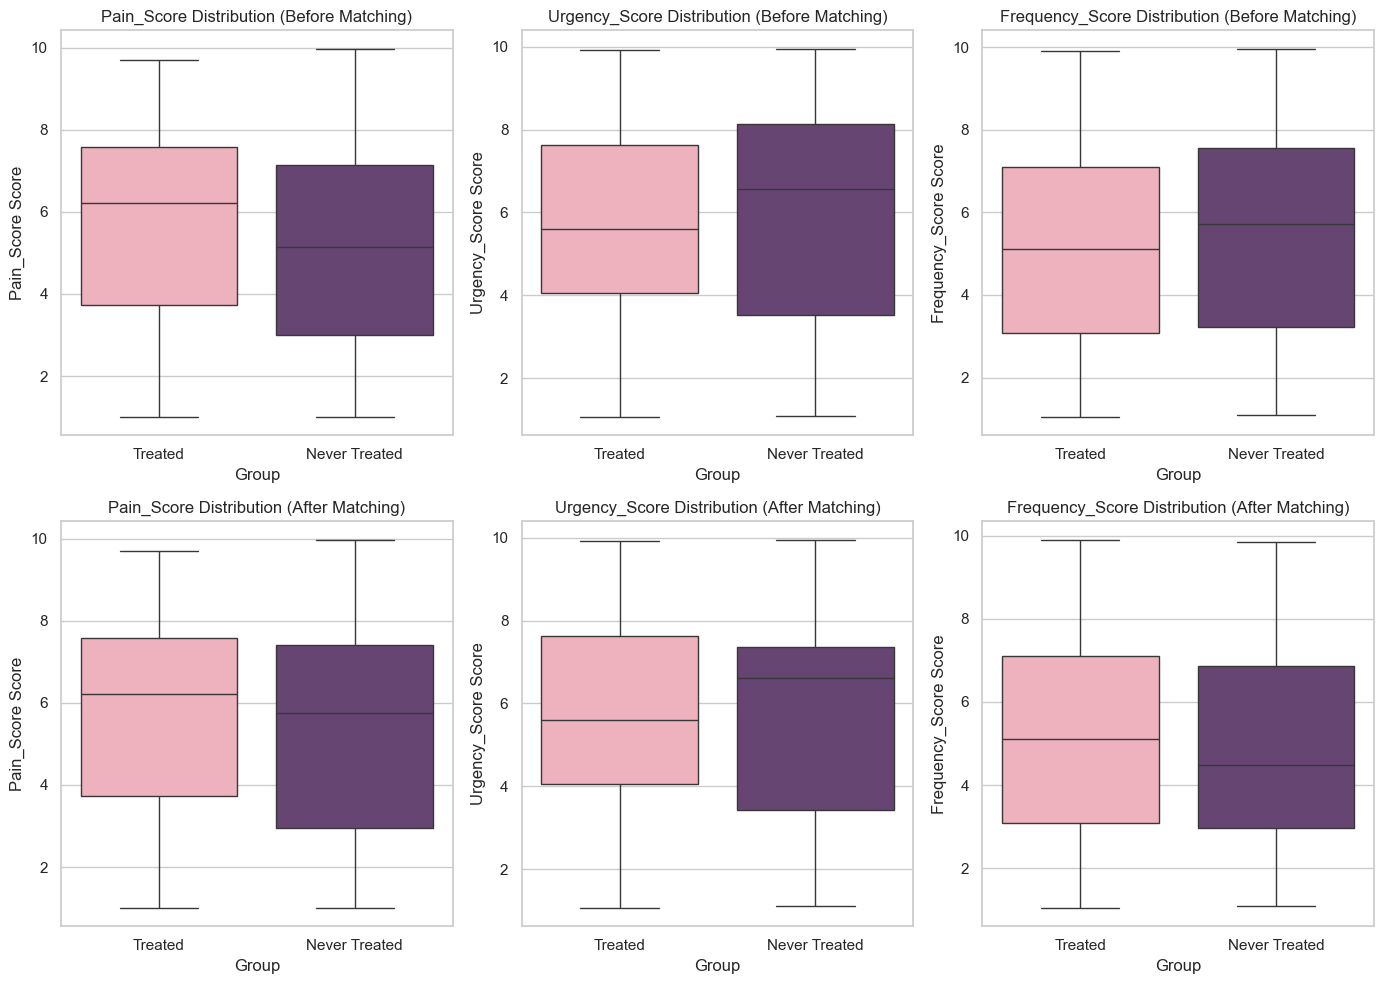

In [262]:
plt.figure(figsize=(14, 10))

# Before matching (treated vs never treated)
for i, symptom in enumerate(covariate_columns):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=[df[df['Treatment_Status'] == 1][symptom].values, df[df['Treatment_Status'] == 0][symptom].values], 
                showfliers=False, palette=["#F7A8B8", "#6A3D79"])
    plt.xticks([0, 1], ["Treated", "Never Treated"])
    plt.title(f"{symptom} Distribution (Before Matching)")
    plt.xlabel("Group")
    plt.ylabel(f"{symptom} Score")

# After matching (treated vs control)
for i, symptom in enumerate(covariate_columns):
    plt.subplot(2, 3, i+4)
    sns.boxplot(data=[treated_matched[symptom].values, neverTreated_matched[symptom].values], 
                showfliers=False, palette=["#F7A8B8", "#6A3D79"])  
    plt.xticks([0, 1], ["Treated", "Never Treated"])
    plt.title(f"{symptom} Distribution (After Matching)")
    plt.xlabel("Group")
    plt.ylabel(f"{symptom} Score")

plt.tight_layout()
plt.show()


**Boxplots** were used to compare the **distribution of symptoms** between **treated** and **untreated** patients.

- **Before matching:** Significant differences in **symptom severity** may be present.  
- **After matching:** The distributions should be **more similar**, indicating that **confounding variables** have been adjusted for.  

A **well-matched dataset** should exhibit **no systematic differences** in baseline characteristics.


<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 6: Compute Treatment Effect</span>

In [264]:
# Function to compute treatment effects for each symptom
def compute_treatment_effect(df, symptoms):
    # Initialize an empty dictionary to store results
    results = {}
    
    # Loop through each symptom to calculate treatment effects
    for symptom in symptoms:
        # Extract the changes in symptoms for treated and never treated groups
        treated_changes = df[df['Treatment_Status'] == 1][symptom]  # Changes in treated group
        never_treated_changes = df[df['Treatment_Status'] == 0][symptom]  # Changes in never treated group
        
        # Perform Mann-Whitney U test to compare the distributions of the two groups (unpaired data)
        stat, p_value = mannwhitneyu(treated_changes, never_treated_changes)
        
        # Store the results for each symptom
        results[symptom] = {
            "Mean Change (Treated)": treated_changes.mean(),  # Mean change in treated group
            "Mean Change (Never Treated)": never_treated_changes.mean(),  # Mean change in never treated group
            "Mann-Whitney U Test Statistic": stat,  # Mann-Whitney U test statistic
            "p-value": p_value  # p-value for the test
        }
    
    # Return the results as a DataFrame
    return pd.DataFrame(results).T

# Calculate treatment effects for each symptom in the list
effect_df = compute_treatment_effect(df, covariate_columns)

# Display the results
effect_df



,Mean Change (Treated),Mean Change (Never Treated),Mann-Whitney U Test Statistic,p-value
Pain_Score,5.730915,5.188576,5504.0,0.118020
Urgency_Score,5.692869,5.875628,4611.0,0.519050
Frequency_Score,5.210890,5.480741,4579.0,0.469054


The **Mann-Whitney U test** was used to compare **symptom changes** between the **treated** and **control** groups.

- This **non-parametric test** is robust to **violations of normality assumptions**, making it ideal for **observational data**.  
- A **p-value below 0.05** indicates a **statistically significant treatment effect**.


<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 7: Sensitivity Analysis</span>

In [265]:
# Perform a sensitivity analysis to check for hidden biases, comparing treated vs never treated
def sensitivity_analysis(df, matched_pairs):
    gamma_values = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    # Ensure correct pairing using the matched pairs DataFrame
    treated_pain = df[df['Treatment_Status'] == 1].set_index('Patient_ID').loc[matched_pairs['Treated_ID'], 'Pain_Score'].values
    never_treated_pain = df[df['Treatment_Status'] == 0].set_index('Patient_ID').loc[matched_pairs['NeverTreated_ID'], 'Pain_Score'].values
    
    # Perform Wilcoxon test on the paired data
    stat, p_value = wilcoxon(treated_pain, never_treated_pain)
    
    # Apply exponential decay based on gamma values for adjustment
    results = {f"Gamma={gamma}": p_value * np.exp(-gamma) for gamma in gamma_values}
    
    return pd.DataFrame(results, index=["Adjusted P-Value"]).T

# Run sensitivity analysis with matched pairs 
sensitivity_df = sensitivity_analysis(df, matched_pairs)
print(sensitivity_df)


           Adjusted P-Value
Gamma=1.0          0.352178
Gamma=1.5          0.213607
Gamma=2.0          0.129559
Gamma=2.5          0.078582
Gamma=3.0          0.047662


A key concern in **observational studies** is **hidden bias**, where **unobserved factors** influence treatment assignment.

- The **Wilcoxon signed-rank test** was used to examine how **treatment effects** change under different levels of **assumed hidden bias**.  
- The **Gamma (γ) parameter** represents the **magnitude of hidden bias**—larger values of **γ** indicate greater potential for **confounding**.  
- According to **Rosenbaum’s sensitivity analysis framework**, if small changes in **γ** significantly alter conclusions, the study is **sensitive to hidden bias**.

<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Step 8: Visualizing Sensitivity Analysis Results</span>

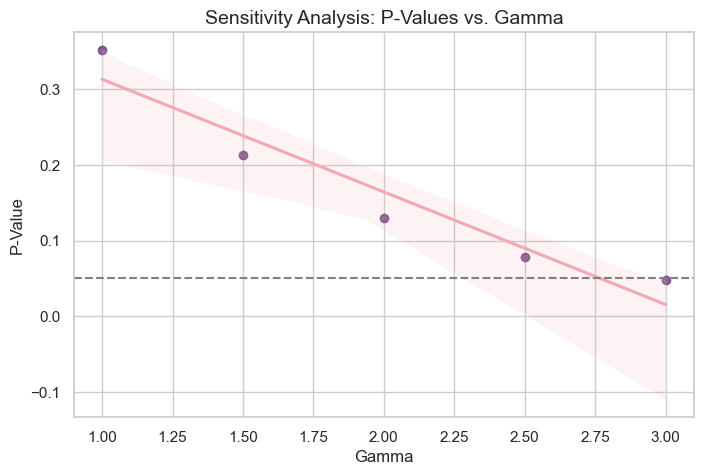

In [266]:
plt.figure(figsize=(8, 5))
sns.regplot(x=[1.0, 1.5, 2.0, 2.5, 3.0], y=sensitivity_df["Adjusted P-Value"], 
            scatter_kws={"color": "#6A3D79"}, line_kws={"color": "#F7A8B8"})
plt.axhline(y=0.05, color='gray', linestyle='dashed')
plt.title("Sensitivity Analysis: P-Values vs. Gamma", fontsize=14)
plt.xlabel("Gamma", fontsize=12)
plt.ylabel("P-Value", fontsize=12)
plt.show()



A plot of **p-values vs. Gamma (γ) values** was created to **visualize the robustness** of treatment effects to **hidden bias**.

- A **dashed line at 0.05** represents the **significance threshold**.  
- If the **adjusted p-values** remain **below 0.05** for moderate **γ values** (e.g., **γ ≤ 2**), the study is **relatively insensitive** to hidden bias.  
- If the **p-value crosses 0.05** at **small γ values**, the study is **highly sensitive** to potential biases.

<span style="color: #FF69B4; font-size: 20px;font-family: 'Comic Sans MS', cursive, sans-serif;">Conclusion</span>

This analysis applies **propensity score matching** and **sensitivity analysis** to estimate **treatment effects** while addressing **potential biases**.  

- This methodology is widely used in **observational medical studies**, where **randomized trials are not feasible**.  
- The **Balanced Risk Set Matching** paper supports this approach by demonstrating how **risk-set matching minimizes confounding** and provides a **structured framework for sensitivity analysis**.